# Memory optimization. Dask

## Data Preprocessing & EDA

In [262]:
import dask.dataframe as dd

ddf = dd.read_csv('data/renfe_trips.csv')
ddf = ddf.repartition(npartitions=4)

In [263]:
for i in range(ddf.npartitions):
  print(ddf.partitions[i].compute().head())

         id company     origin destination            departure  \
0  15400000   renfe  BARCELONA      MADRID  2019-11-11 08:00:00   
1  15400001   renfe  BARCELONA      MADRID  2019-11-11 06:05:00   
2  15400002   renfe  BARCELONA      MADRID  2019-11-11 14:00:00   
3  15400003   renfe  BARCELONA      MADRID  2019-11-11 15:25:00   
4  15400004   renfe  BARCELONA      MADRID  2019-11-11 17:00:00   

               arrival  duration vehicle_type vehicle_class  price   fare  \
0  2019-11-11 11:10:00      3.17          AVE       Turista  85.10  Promo   
1  2019-11-11 09:15:00      3.17          AVE       Turista    NaN  Promo   
2  2019-11-11 17:10:00      3.17          AVE       Turista  85.10  Promo   
3  2019-11-11 17:55:00      2.50          AVE  Turista Plus  70.15  Promo   
4  2019-11-11 19:45:00      2.75          AVE    Preferente  98.00  Promo   

   seats meta          insert_date  
0    NaN   {}  2019-11-06 15:12:12  
1    NaN   {}  2019-11-06 15:12:12  
2    NaN   {}  2019-11-

In [264]:
for i in range(ddf.npartitions):
  print(ddf.partitions[i].describe())

Dask DataFrame Structure:
                    id duration    price    seats
npartitions=1                                    
               float64  float64  float64  float64
                   ...      ...      ...      ...
Dask Name: describe-numeric, 34 graph layers
Dask DataFrame Structure:
                    id duration    price    seats
npartitions=1                                    
               float64  float64  float64  float64
                   ...      ...      ...      ...
Dask Name: describe-numeric, 34 graph layers
Dask DataFrame Structure:
                    id duration    price    seats
npartitions=1                                    
               float64  float64  float64  float64
                   ...      ...      ...      ...
Dask Name: describe-numeric, 34 graph layers
Dask DataFrame Structure:
                    id duration    price    seats
npartitions=1                                    
               float64  float64  float64  float64
           

In [265]:
ddf.isnull().sum().compute()

id                    0
company               0
origin                0
destination           0
departure             0
arrival               0
duration              0
vehicle_type          0
vehicle_class     11898
price             33923
fare              11898
seats            700000
meta                  0
insert_date           0
dtype: int64

In [266]:
ddf = ddf.dropna(subset=['price'])

for i in ['departure', 'arrival']:
  date = dd.to_datetime(ddf[i], errors='coerce')
  ddf[i+'_year'] = date.dt.year
  ddf[i+'_month'] = date.dt.month

ddf = ddf.drop(['id', 'company', 'insert_date', 'meta', 'seats', 'departure', 'arrival'], axis=1)

for i in range(ddf.npartitions):
  print(ddf.partitions[i].compute().head())

      origin destination  duration vehicle_type vehicle_class  price   fare  \
0  BARCELONA      MADRID      3.17          AVE       Turista  85.10  Promo   
2  BARCELONA      MADRID      3.17          AVE       Turista  85.10  Promo   
3  BARCELONA      MADRID      2.50          AVE  Turista Plus  70.15  Promo   
4  BARCELONA      MADRID      2.75          AVE    Preferente  98.00  Promo   
5  BARCELONA      MADRID      3.00          AVE  Turista Plus  80.15  Promo   

   departure_year  departure_month  arrival_year  arrival_month  
0            2019               11          2019             11  
2            2019               11          2019             11  
3            2019               11          2019             11  
4            2019               11          2019             11  
5            2019               11          2019             11  
         origin destination  duration vehicle_type       vehicle_class  price  \
223917  SEVILLA      MADRID      2.53          A

<AxesSubplot: title={'center': 'Fares'}, ylabel='fare'>

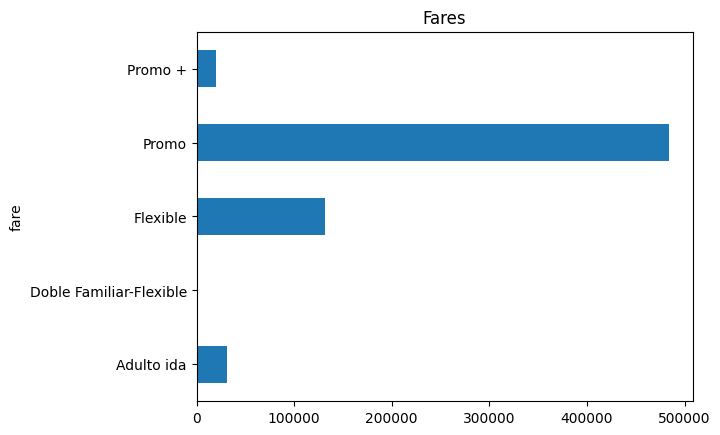

In [268]:
ddf.groupby('fare').size().compute().plot(kind='barh', title='Fares')

<AxesSubplot: title={'center': 'Duration by origin and destination'}, ylabel='origin,destination'>

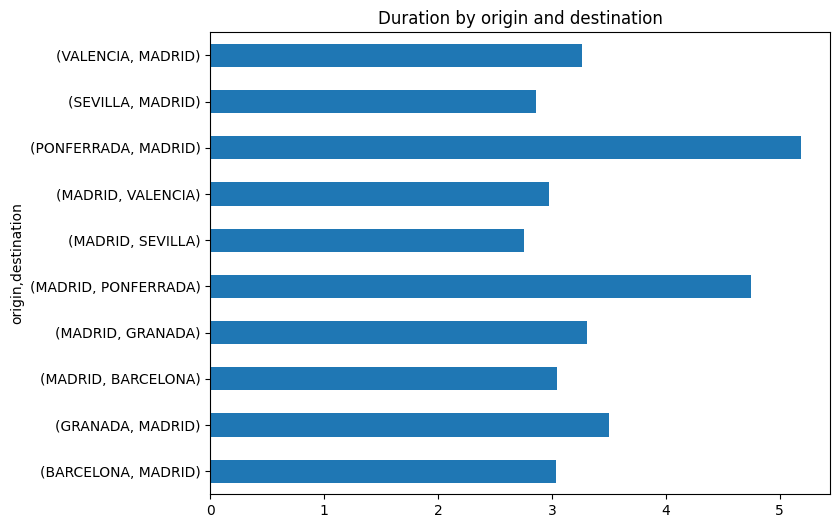

In [269]:
ddf.groupby(['origin', 'destination']).duration.mean().compute().plot(kind='barh', title='Duration by origin and destination', figsize=(8, 6))

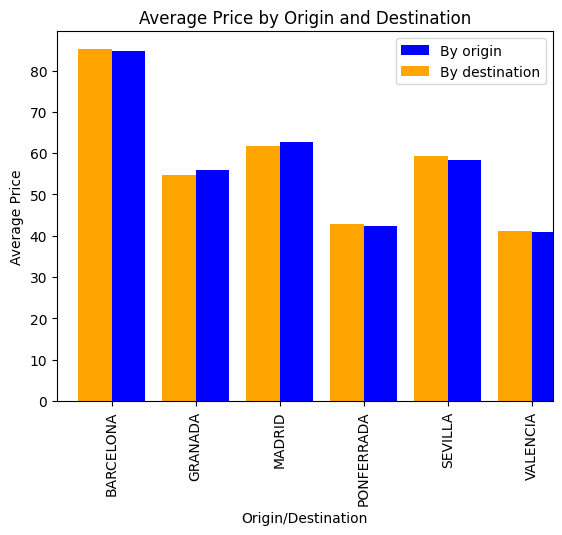

In [270]:
avg_price_origin = ddf.groupby('origin')['price'].mean().compute()
avg_price_destination = ddf.groupby('destination')['price'].mean().compute()

fig, ax = plt.subplots()

avg_price_origin.plot(kind='bar', ax=ax, position=0, width=0.4, color='blue', label='By origin')
avg_price_destination.plot(kind='bar', ax=ax, position=1, width=0.4, color='orange', label='By destination')

ax.set_xlabel('Origin/Destination')
ax.set_ylabel('Average Price')
ax.set_title('Average Price by Origin and Destination')

ax.legend()


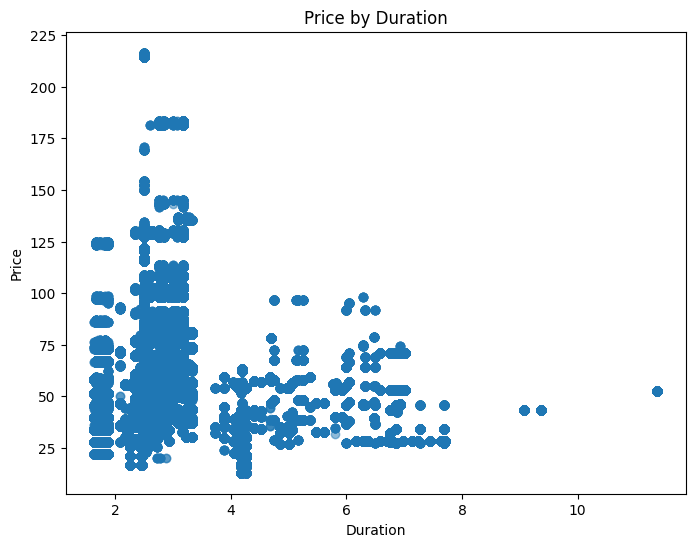

In [271]:
import matplotlib.pyplot as plt

ddf_pd = ddf.compute()

plt.figure(figsize=(8, 6))
plt.scatter(ddf_pd['duration'], ddf_pd['price'], alpha=0.5)
plt.xlabel('Duration')
plt.ylabel('Price')
plt.title('Price by Duration')
plt.show()

## Model Training

In [277]:
from dask_ml.model_selection import train_test_split

X = ddf.drop('price', axis=1)
y = ddf['price']

cat_cols = [i for i in X.columns if X[i].dtype == 'object']
X = X.categorize(columns=cat_cols)
X = dd.get_dummies(X, columns=cat_cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

X_train = X_train.to_dask_array(lengths=True)
X_test = X_test.to_dask_array(lengths=True)
y_train = y_train.to_dask_array(lengths=True)
y_test = y_test.to_dask_array(lengths=True)

In [278]:
from dask_ml.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

accuracy = lr.score(X_test, y_test)

print("Accuracy:", accuracy)

Accuracy: 0.8007128546018171
